# Benchmarking Interpolation 1D

On the 5th of Arpil, the bottleneck of the 1D pic code is the pusher. More importantly, the 1D interpolation.

Here we benchmark 3 methods.


# The 3 methods

## Scipy interp1d

## Numpy interp
Cannot extrapolate at the end

need to be sorted

## Scipy InterpolatedUnivariateSpline

## Numba function


In [65]:
#import the libs and defined usefull functions
import sys 
sys.path.insert(0, '/home/tavant/these/code/1D_PIC')
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d  as interp1
from scipy.interpolate import InterpolatedUnivariateSpline  as interp2
from pic.functions import numba_interp1D  as interp3
from numpy import interp as interp4

def vects(Nx,Np,dx):
    xg = np.arange(Nx+1)*dx
    Eg = np.random.random(Nx+1)*1e3
    xp = np.sort(np.random.random(Np)*(Nx+1) - 0.5)*dx
    return xg, Eg, xp
def plotgrid():
    plt.plot(xg,Eg,'o', label = "Grid value" )
    plt.xlim((-0.5)*dx,(Nx+0.5)*dx)

# Initiate parameters and tests the functions

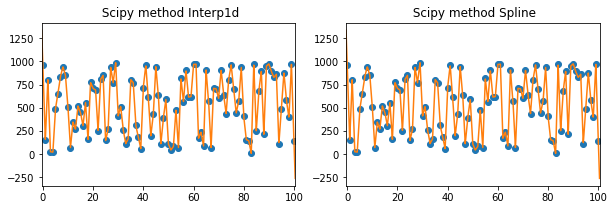

In [3]:
#calculate
Nx = 100
Np = 60*Nx
dx = 1.0
xg, Eg, xp = vects(Nx,Np,dx)

E1 = interp1(xg,Eg, bounds_error=False, fill_value="extrapolate")
Ep1 = E1(xp)
E2 = interp2(xg,Eg,k=1, ext=0)
Ep2 = E2(xp)

#plot
plt.figure(figsize=(10,3))
plt.subplot(121)
plotgrid()
plt.plot(xp,Ep1)
plt.title(" Scipy method Interp1d")

plt.subplot(122)
plotgrid()
plt.plot(xp,Ep2)
plt.title(" Scipy method Spline")
plt.show()

## Numba functions

In [4]:
from numba import jit

In [50]:
@jit('f8[:](f8[:],f8[:],f8[:], f8)')
def numba_interp1D(partx, tabx, tabE, dx):
    """Compute the lineare interpolation of the electric field in the X directions
    This numba function should be faster than the scipy.interp1d and numpy.interp

    """
    partE = np.zeros_like(partx)
    normedx = (tabx/dx).astype(int)
    maxX = int(normedx[-1])
    for i in np.arange(len(partx)):
        x = partx[i]/dx
        if x < 0:
            j = 0
            deltax = x
            partE[i] = ((1-deltax)*tabE[0] + ( deltax)*tabE[1])
        elif x > maxX:
            j = maxX
            deltax = (x - maxX)
            partE[i] = ((1+deltax)*tabE[j] - ( deltax)*tabE[j-1])
        else:
            j = int(x) #position of the particle, in intex of tabx
            deltax = abs(x - normedx[j]) #length to cell center
            partE[i] = ((1-deltax)*tabE[j] + ( deltax)*tabE[j+1])

    return partE

In [29]:
@jit('f8[:](f8[:],i8[:],f8[:])')
def numba_interp1D_normed(partx, normedx, tabE):
    """Compute the lineare interpolation of the electric field in the X directions but with normed position
    This numba function should be faster than the scipy.interp1d and numpy.interp

    """
    partE = np.zeros_like(partx)
    maxX = int(normedx[-1])
    
    for i in np.arange(len(partx)):
        x = partx[i]
        if x < 0:
            deltax = x
            partE[i] = ((1-deltax)*tabE[0] + ( deltax)*tabE[1])
        elif x > maxX:
            j = maxX
            deltax = (x - maxX)
            partE[i] = ((1+deltax)*tabE[j] - ( deltax)*tabE[j-1])
        else:
            j = int(x) #position of the particle, in intex of tabx
            deltax = abs(x - normedx[j]) #length to cell center
            partE[i] = ((1-deltax)*tabE[j] + ( deltax)*tabE[j+1])

    return partE

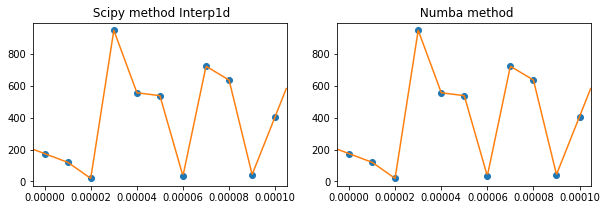

In [71]:
#calculate
Nx = 10
Np = 60*Nx
dx = 1e-5
xg, Eg, xp = vects(Nx,Np,dx)

E1 = interp1(xg,Eg, bounds_error=False, fill_value="extrapolate")
Ep1 = E1(xp)
Ep3 = numba_interp1D(xp,xg,Eg,dx)

#plot
plt.figure(figsize=(10,3))
plt.subplot(121)
plotgrid()
plt.plot(xp,Ep1)
plt.title(" Scipy method Interp1d")

plt.subplot(122)
plotgrid()
plt.plot(xp,Ep3)
plt.title(" Numba method")
plt.show()

# Validation of the 3 methods

In [72]:
def interpalate_all():
    E2 = interp2(xg,Eg,k=1, ext=0)
    Ep2 = E2(xp)
    
    E1 = interp1(xg,Eg, bounds_error=False, fill_value="extrapolate")
    Ep1 = E1(xp)

    Ep3 = numba_interp1D(xp,xg,Eg,dx)

    return Ep1, Ep2, Ep3

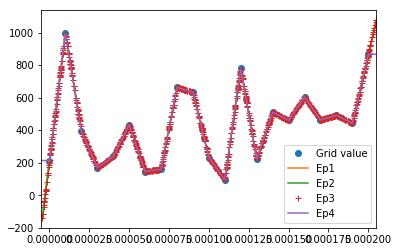

In [74]:
#calculate and plot
Nx = 20
Np = 60*Nx
dx = 1e-5
xg, Eg, xp = vects(Nx,Np,dx)

Ep1, Ep2, Ep3 = interpalate_all()

plotgrid()
plt.plot(xp,Ep1, label = "Ep1")
plt.plot(xp,Ep2, label = "Ep2")
plt.plot(xp,Ep3,"+", label = "Ep3")
plt.plot(xp,interp4(xp,xg,Eg), label='Ep4')
plt.legend()

# Speed measurement and Benchmark

In [83]:
def timit(normed = False):
    print(f"dx = {dx:2.2e}")
    print("Scipy 1 :              ",end="")
    %timeit E1 = interp1(xg,Eg, bounds_error=False, fill_value="extrapolate"); Ep1 = E1(xp)
    print("Scipy 2 :              ",end="")
    %timeit E2 = interp2(xg,Eg,k=1, ext=0); Ep2 = E2(xp)
    print("Numpy   :              ",end="")
    %timeit Ep4 = interp4(xp,xg,Eg)
    print("Numba (normed or not): ",end="")
    
    if normed:
        %timeit xgn = xg.astype(int); Ep3 = numba_interp1D_normed(xp,xgn,Eg)
    else:
        %timeit Ep3 = numba_interp1D(xp,xg,Eg,dx)
        
    print(abs(Ep3-Ep1).mean(), abs(Ep2-Ep1).mean(), abs(Ep2-Ep3).mean() )
    print("")

In [84]:
#small system
Nx = 20
Np = 10*Nx

# Test with float dx
dx = 1e-5
xg, Eg, xp = vects(Nx,Np,dx)
timit()
# Test with normalised dx
dx = 1
xg, Eg, xp = vects(Nx,Np,dx)
timit(normed = True)


dx = 1.00e-05
Scipy 1 :              48.5 µs ± 922 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Scipy 2 :              26.8 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Numpy   :              3.12 µs ± 87.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Numba (normed or not): 10.2 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.0378660893669197e-13 2.903751313472943e-14 1.0871303857129533e-13

dx = 1.00e+00
Scipy 1 :              51.2 µs ± 987 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Scipy 2 :              29.1 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Numpy   :              3.48 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Numba (normed or not): 2.31 µs ± 15.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.0378660893669197e-13 2.903751313472943e-14 1.0871303857129533e-13



In [85]:
#Big system
Nx = 1000
Np = 100*Nx

# Test with float dx
dx = 3e-5
xg, Eg, xp = vects(Nx,Np,dx)
timit()
# Test with normalised dx
dx = 1
xg, Eg, xp = vects(Nx,Np,dx)
timit(normed = True)


dx = 3.00e-05
Scipy 1 :              3.63 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Scipy 2 :              1.41 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Numpy   :              517 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Numba (normed or not): 642 µs ± 9.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.0378660893669197e-13 2.903751313472943e-14 1.0871303857129533e-13

dx = 1.00e+00
Scipy 1 :              3.64 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Scipy 2 :              1.31 ms ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Numpy   :              533 µs ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Numba (normed or not): 641 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.0378660893669197e-13 2.903751313472943e-14 1.0871303857129533e-13



# Conclusion

Numpy interp is faster than Numba on big systems, be slightly slower on normed small on.
However, it does not extrapolate at the exterior.

In order to use Numpy, extrapolation will have to be done before calling the function, by adding boundary cells